### Part2 Trend Analysis

Analysis part is described: BoW, IDF/TF, word2vec, WordCloud

### Import Libraries

In [1]:
import os
import re
import copy
import string
import operator
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
from matplotlib.dates import YearLocator
from collections import Counter,OrderedDict
from dateutil import parser

### Load pre-processed documents from text files

In [2]:
def load_preprocessed_docs(keys_year,path_file,stop_words):
    ''' Load text files and store them in a dictionary '''
    words_year = dict((y,[]) for y in keys_year)
    words_article = []
    dates_str = []
    for file_name in os.listdir(path_file):
        if not file_name.endswith('0000.00.00.txt'):
            # Open a file to read text that has been already preprocessed.
            file = open(os.path.join(path_file,file_name),'r')
            text = file.read()
            file.close()
            words_list = text.split()
            words_list = [word for word in words_list if word not in stop_words] # Remove stop words
            words_list = ' '.join(words_list)

            # Determine which dictionary key to add words.
            date = parser.parse(file_name.split('_')[-1][:-4])
            year_str = str(date.year)
            month_str = str(date.month).rjust(2,'0')
            if int(year_str) >= year_start:
                words_year[year_str].append(words_list)
                words_article.append(words_list)
                dates_str.append(year_str + '-' + month_str + '-01')

    dates_article = [pd.to_datetime(d) for d in dates_str]
    return words_year, words_article, dates_article

In [3]:
# Define stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
import nltk
_ = nltk.download('stopwords', quiet=True)

stop_words_nltk = nltk.corpus.stopwords.words('english')
stop_words_sklearn = list(sklearn_stop_words)
stop_words_own = ['week','copyright','report','project','outlook','month','year','fact','bd',
                  'kbd','bcf','bcm','tcf','bcfd','boed','mmtpa','mmboe','million','billion']
stop_words = list(sklearn_stop_words.union(stop_words_nltk)) + stop_words_own

In [4]:
path_folder = './articles_text'
year_start, year_end = 2013, 2019
keys_year = ' '.join(map(str,np.arange(year_start,year_end+1,1))).split()
words_year, words_article, dates_article = load_preprocessed_docs(keys_year,path_folder,stop_words)

### Convert Articles into Bag of Words (BoWs)

In [5]:
def bag_of_words(keys_year,words_year,words_article,bow_func):
    ''' Create bag of words (BOW) using Counter'''
    
    # Bag of words for each year
    bow_year = dict((y,[]) for y in keys_year)
    for year in keys_year:
        words_list = ' '.join(words_year[year]).split()
        bow_year[year] = bow_func(words_list)

    # Bag of words for all the articles
    words_all_list = ' '.join(words_article).split()
    bow_all = bow_func(words_all_list)
    
    # Bag of words for each article
    bow_article = dict((i,[]) for i in range(len(words_article)))
    for i,article in enumerate(words_article):
        bow_article[i] = bow_func(article.split())
    return bow_year, bow_all, bow_article

In [6]:
bow_func = lambda x: OrderedDict(sorted(Counter(x).items(),key=lambda item:(-item[1],item[0])))
bow_year, bow_all, bow_article = bag_of_words(keys_year,words_year,words_article,bow_func)

### Calculate Inverse Document Frequency and Term Frequency

In [7]:
def get_idf(words_article,bow_all):
    # Inverse Document Frequency (IDF)
    idf_dict = {word: 0 for word in list(bow_all)}
    for article in words_article:
        for word,_ in idf_dict.items():
            if word in article:
                idf_dict[word] += 1
    idf_dict = {k: np.log10(len(words_article)/v) for k, v in idf_dict.items()}
    return idf_dict

In [8]:
def get_tfidf(idf_dict,bow_all,bow):
    ''' TF-IDF is a word score that better represents its importance than word count. '''
    keys = list(bow.keys())
    # Term Frequency (TF)
    tf_dict = dict((y,{word: 0 for word in list(bow_all)}) for y in keys)
    for key in keys:
        num_unique = len(bow[key])
        for word,count in bow[key].items():
            tf_dict[key][word] = count / num_unique

    # Term Frequency times Inverse Document Frequency (TF-IDF)
    tfidf_dict = dict((y,{word: 0 for word in list(bow_all)}) for y in keys)
    for key in keys:
        for word,count in bow[key].items():
            tfidf_dict[key][word] = tf_dict[key][word] * idf_dict[word]    
    return tfidf_dict, tf_dict

In [9]:
idf_dict = get_idf(words_article,bow_all)
tfidf_dict_year,tf_dict_year = get_tfidf(idf_dict,bow_all,bow_year)
tfidf_dict_article,tf_dict_article = get_tfidf(idf_dict,bow_all,bow_article)

### Vectorize bag of words by word2vec

In [10]:
def vectorize_bow(tfidf_dict,word_vectors,bow):
    ''' Vectorize Bag of Words for each key '''
    keys = list(bow.keys())
    tfidf_rev = copy.deepcopy(tfidf_dict)
    words_unknown = []
    vectors = np.zeros([len(bow),word_vectors.vector_size])
    for i, key in enumerate(keys):
        # Find a vector in word2vec
        for word,cnt in bow[key].items():
            word_search = None
            if word.capitalize() in word_vectors.vocab:
                word_search = word.capitalize()
            elif word in word_vectors.vocab:
                word_search = word
            elif word.upper() in word_vectors.vocab:
                word_search = word.upper()
                
            # Add a corresponding vector multiplied by importance factor (TF-IDF)
            if word_search:
                vectors[i,:] += tfidf_rev[key][word] * word_vectors[word_search]
                tfidf_rev[key][word_search] = tfidf_rev[key].pop(word)
            # Save unknown words and remove from TF-IDF dictionary for visualization purpose
            else:
                words_unknown.append(word)
                tfidf_rev[key].pop(word)
        # Normalize a vector
        vectors[i,:] /= sum(tfidf_rev[key].values())
    
    words_unknown = bow_func(words_unknown)
    return vectors, words_unknown, tfidf_rev

In [11]:
# Load Word2Vec from downloaded file
from gensim.models.keyedvectors import KeyedVectors
path_word2vec = './GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

# Download Word2Vec from the nlpia package
# from nlpia.data.loaders import get_data
# word_vectors = get_data('word2vec')

In [12]:
# Load preprocessed text files and convert them into word vectors
vectors_year, words_unknown, tfidf_rev = vectorize_bow(tfidf_dict_year,word_vectors,bow_year)
vectors_article, _, _ = vectorize_bow(tfidf_dict_article,word_vectors,bow_article)

### Show word-count histogram

In [13]:
def hist_freq_word(bow_all,num_rank):
    ''' Word count histogram '''
    word = list(bow_all.keys())[:num_rank]
    freq = list(bow_all.values())[:num_rank]
    fig, ax = plt.subplots(figsize=(15,4))
    plt.bar(word, freq, width=0.5, color='g')
    ax.set_xticklabels(word, rotation=30)
    ax.set_xlim([-0.5, num_rank-0.5])
    ax.set_ylim([0,4000])
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.title('Most Frequent Words Top ' + str(num_rank))
    for i in range(num_rank):
        plt.text(x=i-0.35, y=freq[i]+80, s=freq[i], size=8)
    plt.show()

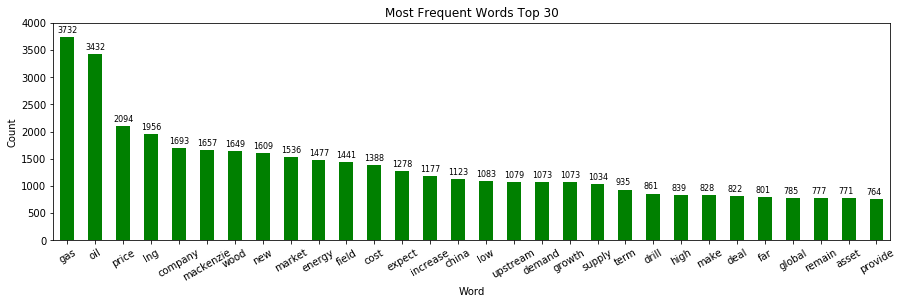

In [14]:
num_rank = 30
hist_freq_word(bow_all,num_rank)

### Visualize Bag of Words by Wordcloud

In [15]:
from wordcloud import WordCloud

In [16]:
def show_wordcloud(tfidf,keys_year):
    ''' Show Wordcloud Image for each year's Bag of Words '''
    i = 0
    fig = plt.figure(figsize=(14,14))
    for year in keys_year:
        fig.add_subplot(421 + i)
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(tfidf[year])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(year,fontsize=14)
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

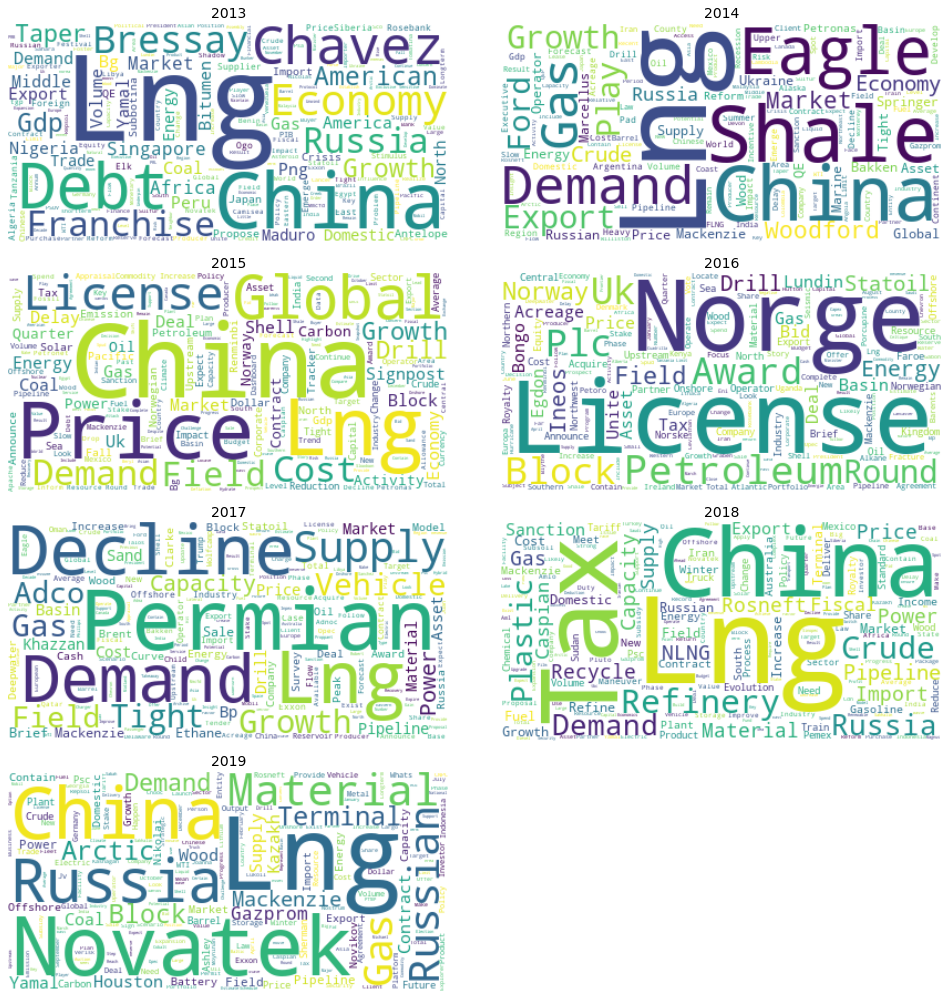

In [17]:
show_wordcloud(tfidf_rev,keys_year)

### Define "ness" vectors

In [18]:
def component_vector(words,word_vectors):
    vector = pd.np.zeros(300)
    for word in words:
        v = word_vectors[word]
        vector += v / len(words)
    return vector

In [19]:
def nessvector(target, components, word_vectors):
    ''' Create "ness" vector  '''
    target = word_vectors[target] if isinstance(target, str) else target
    vector = word_vectors.cosine_similarities(target, components.values)
    return pd.Series((vector - vector.mean()) / .15, index=components.index)

In [20]:
# Ness Array
ness_keys = ['Upturn','Environment','Americas','Europe','Asia']
COMPONENT_WORDS = OrderedDict([
    (ness_keys[0], 'upturn investment boom growth'.split()),    
    (ness_keys[1], 'climate environment renewable nature clean'.split()),
    (ness_keys[2], 'Americas America Latin_America Brazil Argentine US oil gas'.split()),
    (ness_keys[3], 'Europe Norway UK Russia oil gas'.split()),
    (ness_keys[4], 'Japan China Southeast_Asia oil gas'.split()),
])

wv_ness = [component_vector(words,word_vectors) for (component, words) in COMPONENT_WORDS.items()]
idx_ness = [component for (component, words) in COMPONENT_WORDS.items()]
components = pd.DataFrame(wv_ness, index=idx_ness)

# Convert each article vector to ness vector
dates_yq =pd.PeriodIndex(dates_article, freq='Q').start_time.to_list()
ness_article = vectors_article @ components.values.T
ness_article = (ness_article - ness_article.mean(axis=0)) / ness_article.std(axis=0)
df = pd.DataFrame(list(zip(dates_yq,*ness_article.T)), columns=['Date'] + ness_keys)
df['Date'] = pd.to_datetime(df['Date']).dt.date

### Plot trends for each "ness"

In [21]:
def AxisTimeSeries(ax,ParamAxis,i):
    ax.set_xlim(ParamAxis['MinX'],ParamAxis['MaxX'])
    ax.set_ylim(ParamAxis['MinY'],ParamAxis['MaxY'])
    ax.set_yticks(np.arange(ParamAxis['MinY'],ParamAxis['MaxY']+0.1,ParamAxis['MajorY']))
    ax.set_yticks(np.arange(ParamAxis['MinY'],ParamAxis['MaxY']+0.1,ParamAxis['MinorY']),minor=True)
    if i == 0:
        ax.xaxis.set_major_locator(YearLocator(ParamAxis['MajorX'],month=1,day=1))
        ax.xaxis.set_minor_locator(YearLocator(ParamAxis['MinorX'],month=1,day=1))
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')
    ax.patch.set_facecolor('Gainsboro')

In [22]:
def plot_article_trend(prices,tick_label,df):
    list_clr = ['crimson','indigo','darkgreen','tomato','darkblue']
    ylabels = ['Oil Price [$/bbl]','Normalized feature','Normalized feature']
    fig, axes = plt.subplots(3,1, figsize=(14,18))
    for i,ax in enumerate(axes):
        ax = plt.axes(ax)
        if i == 0:
            plt.plot(prices.Date, prices.WTI, 'green',label='Oil Price (WTI)')
            ParamAxis={'MinX': datetime.date(2012,11,1),'MaxX':datetime.date(2020,1,1),
                       'MajorX':2,'MinorX':1,'MinY':20,'MaxY':120,'MajorY':20,'MinorY':10}
            title = 'WTI Oil Price'
        else:
            label_list = []
            ParamAxis={'MinX':-2/3,'MaxX':len(tick_label),'MinY':-1.2,'MaxY':1.2,'MajorY':.4,'MinorY':.2}
            if i == 1:
                for j in [0,1]:
                    sns.pointplot(x="Date",y=ness_keys[j],data=df,capsize=.2,color=list_clr[j],
                                  errwidth=1,scale=.75,ci=68.27)
                    label_list.append(ness_keys[j])
            else:
                for j in [2,3,4]:
                    sns.pointplot(x="Date",y=ness_keys[j],data=df,capsize=.2,color=list_clr[j],
                                  errwidth=1,scale=.75,ci=68.27)
                    label_list.append(ness_keys[j])                
                ax.set_xticklabels(tick_label[0::4])
            ax.set_xticks(ax.get_xticks()[0::4])            
            title = '/'.join(label_list) + ' "ness" (error bar: 1 sigma)'
            ax.legend(handles=ax.lines[::int(len(ax.lines)/len(label_list))], labels=label_list, loc='lower right')
            plt.xlabel('')            
        AxisTimeSeries(ax,ParamAxis,i)
        plt.title(title,fontsize=14)
        plt.ylabel(ylabels[i],fontsize=12)
    plt.subplots_adjust(hspace = 0.3)
    plt.show()

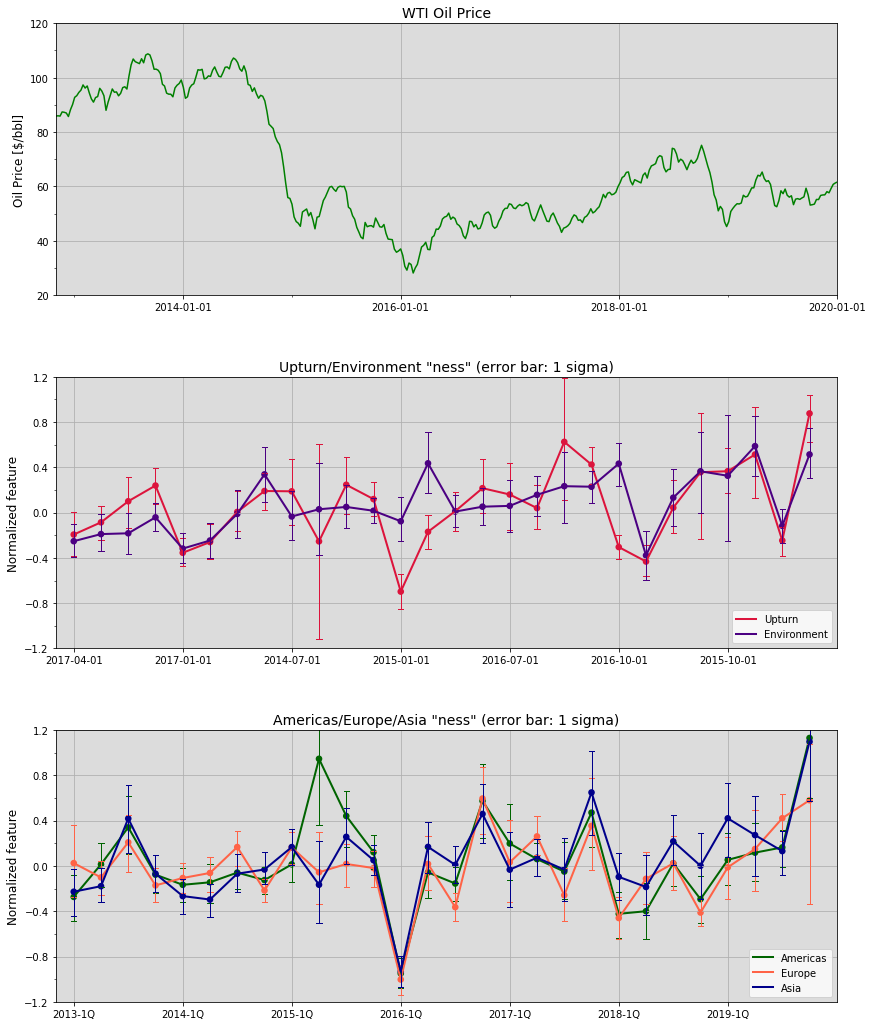

In [24]:
# Load Oil Price History
prices = pd.read_csv('./prices.csv')
prices['Date'] = pd.to_datetime(prices['Date']).dt.date
years = np.arange(year_start,year_end+1,1).tolist()
tick_label = [str(year) + '-' + str(qtr) + 'Q' for year in years for qtr in [1,2,3,4]]
plot_article_trend(prices,tick_label,df)